# Experiments with the one vs rest  multiclass classification scheme

In [2]:
%matplotlib inline

from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier as OvR
from sklearn.svm import LinearSVC
import numpy as np
import copy
from matplotlib import pyplot as plt

In [3]:
digits = datasets.load_digits()

We will use the "Optical Recognition of Handwritten Digits Data Set" from UCI (included in scikit learn and already loaded on the previous line). Let us plot the first 10 images in the dataset.

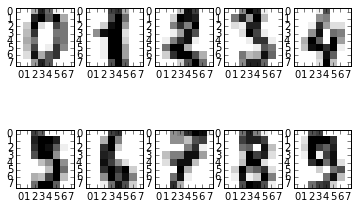

In [4]:
for index, image in enumerate(digits.images[:10]):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Let us create a training set using the first 1000 images and a test set using the rest of the data.

In [6]:
X,y = digits.data[0:1000], digits.target[0:1000]
X_test, y_test = digits.data[1000:], digits.target[1000:]
print(X[0])

[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.   5.
   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.   0.   8.
   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.  11.   0.   1.
  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.   0.   0.   6.  13.
  10.   0.   0.   0.]


scikit-learn provide us with an One-Vs-Rest classifier that we already imported with name `OvR`. Let us use that classifier to fit the training set and to make predictions over the test set:

In [ ]:
binaryLearner = LinearSVC(random_state=0)

oneVrestLearningAlgorithm = OvR(binaryLearner)
oneVrestLearningAlgorithm.fit(X,y)
predicted_labels = oneVrestLearningAlgorithm.predict(X_test)

# n.b.: the above is equivalent to:
# predicted_labels = OvR(LinearSVC(random_state=0)).fit(X,y).predict(X_test)

In [ ]:
print "Accuracy: %s" % (1.0 - np.count_nonzero(y_test - predicted_labels) / float(len(predicted_labels)))

# Exercise

Reimplement the OvR classifier by completing the methods in the following class [[1](#hint1)]:

In [ ]:
class OneVsRestClassifier:
    def __init__(self, learner):
        #... to be done ...
        return 1

    def fit(self, data, labels):
        #... to be done ...

        return self

    def predict(self, data):
        #... to be done ...
        return 1

Calculate the accuracy of your solution using the following code [[2](#hint2)]:

In [ ]:
ovr = OneVsRestClassifier(LinearSVC(random_state=0))
predicted_labels = ovr.fit(X,y).predict(X_test)
print "Accuracy: %s" % (1.0-np.count_nonzero(predicted_labels-y_test)/float(len(y_test)))

<a name="hint1">Hint 1:</a> Feel free to organize your code as you like (add as many methods as you believe are necessary).

<a name="hint2">Hint 2:</a> The scheme provided by scikit-learn is a little different from the one we have seen in the lessons. It is normal if your accuracy is not as good as the one obtained above (expect the accuracy to be between 0.8 and 0.9).